In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
import scipy.interpolate as interp
import time
from tqdm import tqdm
from IPython import display

import tensorflow as tf
print(tf. __version__)

from scipy.io import loadmat
from scipy import linalg
from scipy.special import lambertw as lambertw
import numba as nb

2.10.0


In [2]:
%matplotlib notebook

In [3]:
from SQ_NN import SQ_NN, SQ_NN_tf, Decoder_aug

In [47]:
# Training set
parameters_zscore = 0
sq_min = np.exp(-5) # minimum of sq

if 1:
    X_file = './training_set/input_grid_all_GPR80.csv'
    Y_file = './training_set/target_grid_all.csv'
else:
    X_file = './training_set/input_random_all_GPR80.csv'
    Y_file = './training_set/target_random_all.csv'
    
fX = open(X_file, 'r', encoding='utf-8-sig')
sq = np.genfromtxt(fX, delimiter=',').astype(np.float32)
sq[sq<=0] = sq_min

fY = open(Y_file, 'r', encoding='utf-8-sig')
target = np.genfromtxt(fY, delimiter=',').astype(np.float32)

eta = target[:,0]
kappa = target[:,1]
Z = target[:,3]
A = target[:,2]
lnZ = np.log(Z)
lnA = np.log(A)

eta_mean = np.mean(eta)
eta_std = np.std(eta)
kappa_mean = np.mean(kappa)
kappa_std = np.std(kappa)
A_mean = np.mean(A)
A_std = np.std(A)

# normalization
eta_z = (eta-eta_mean)/eta_std
kappa_z = (kappa-kappa_mean)/kappa_std
A_z = (A-A_mean)/A_std

if parameters_zscore:
    parameters_train = np.array([eta_z,kappa_z,A_z]).T
else:
    parameters_train = np.array([eta,kappa,A]).T

sq_dim = sq.shape[1]
sample_train_dim = sq.shape[0]
q = (np.arange(sq_dim)+1)*0.2
q_rs = (np.arange(sq_dim)+1)*0.2
q_rs_dim = q_rs.shape[0]

# rescale
r_eta = 1
sq_rs = np.zeros((sample_train_dim,q_rs_dim),dtype='float32')
for i in range(sample_train_dim):
    qr_eta = q*r_eta
    interpolating_function = interp.interp1d(qr_eta[3:],sq[i,3:],fill_value='extrapolate')
    sq_rs[i,:] = interpolating_function(q_rs).astype(np.float32)
sq_rs[sq_rs<=0] = sq_min

print('eta ~ N({:0.4f},{:0.4f})'.format(np.mean(eta),np.var(eta)))
print('kappa ~ N({:0.4f},{:0.4f})'.format(np.mean(kappa),np.var(kappa)))
print('A ~ N({:0.4f},{:0.4f})'.format(np.mean(A),np.var(A)))

eta ~ N(0.2325,0.0169)
kappa ~ N(0.2600,0.0208)
A ~ N(13.0000,52.0000)


In [28]:
# from scipy.io import loadmat
# filename_EQSANS = './EQSANS.mat'
# loaded_EQSANS = loadmat(filename_EQSANS)
# q_EQSANS_0 = loaded_EQSANS['Q_real'][:,0]#.astype('float32')
# qsig_EQSANS = loaded_EQSANS['qsig'][:,0]#.astype('float32')
# data = loaded_EQSANS['data']#.astype('float32')
# qsig_EQSANS[qsig_EQSANS==0] = np.ones(np.sum(qsig_EQSANS==0))*np.min(qsig_EQSANS[qsig_EQSANS!=0])
# q_EQSANS = q_EQSANS_0*16/max(q_EQSANS_0)
# qsig_EQSANS = qsig_EQSANS*16/max(q_EQSANS_0)

data_EQSANS = np.loadtxt('./EQSANS.txt',delimiter=',',skiprows=2)
q_EQSANS_0 = data_EQSANS[:,0]#.astype('float32')
qsig_EQSANS = data_EQSANS[:,3]#.astype('float32')
IQ_EQSANS = data_EQSANS[:,1]#.astype('float32')
E_EQSANS = data_EQSANS[:,2]#.astype('float32')

qsig_EQSANS[qsig_EQSANS==0] = np.ones(np.sum(qsig_EQSANS==0))*np.min(qsig_EQSANS[qsig_EQSANS!=0])
q_EQSANS = q_EQSANS_0*16/max(q_EQSANS_0)
qsig_EQSANS = qsig_EQSANS*16/max(q_EQSANS_0)

In [30]:
def hardsphere(q,sigma=1):
    R = sigma/2
    P = (3*(np.sin(q*R)-q*R*np.cos(q*R))/(q*R)**3)**2
    return P

def scale(q,x,scale):
    qs = q*scale
    f_interp = interp.interp1d(qs, x, fill_value='extrapolate')
    x_interp = f_interp(q)
    return x_interp

def IQ_resoln(Q, Q_fine, IQ_th, dQ):
    '''
    Q: Q of the instrument resolution function
    Q_fine: A set of smooth Q points
    IQ_th: I(Q), interpolated to Q_fine
    dQ: The instrument resolution function
    '''
    
    Qmean = Q
    N = len(Q)
    IQ = []
    
    for i in range(N):
        current_dQ = dQ[i]
        current_Qmean = Qmean[i]
        w_gauss = (1/np.sqrt(2*np.pi*current_dQ**2))*np.exp(-(Q_fine-current_Qmean)**2/(2*current_dQ**2))
        IQ_resoln = IQ_th*w_gauss
        
        IQ.append(np.trapz(IQ_resoln,Q_fine)/np.trapz(w_gauss,Q_fine))

    IQ_out = np.array(IQ)
    return IQ_out

def SQ_th(sq_func,fp):
    # structure factor
    return sq_func(fp[0:3])

def IQ_th(sq_func,fp):
    # form factor
    P = hardsphere(q,1)

    # structure factor
    S = SQ_th(sq_func,fp)

    # I(Q)
    IQ = S*P*fp[4]+fp[5]

    # resolution
    Q = q_EQSANS
    dQ = qsig_EQSANS
    Q_fine = np.linspace(0.2,16,100)

    f_interp = interp.interp1d(q,IQ)
    IQ_Qfine = f_interp(Q_fine)
    IQ_res = IQ_resoln(Q, Q_fine, IQ_Qfine, dQ)

    IQ_res_scale = scale(Q,IQ_res,fp[3])
    f_interp = interp.interp1d(Q,IQ_res_scale)
    
    IQ_res_scale_interp = f_interp(q_rs)
    return IQ_res_scale_interp



In [32]:
def IQ_exp(sq_GT,fp):
    # form factor
    P = hardsphere(q,1)

    # structure factor
    S = sq_GT

    # I(Q)
    IQ = S*P*fp[4]+fp[5]

    # resolution
    Q = q_EQSANS
    dQ = qsig_EQSANS
    Q_fine = np.linspace(0.2,16,100)

    f_interp = interp.interp1d(q,IQ)
    IQ_Qfine = f_interp(Q_fine)
    IQ_res = IQ_resoln(Q, Q_fine, IQ_Qfine, dQ)

    IQ_res_scale = scale(Q,IQ_res,fp[3])
    f_interp = interp.interp1d(Q,IQ_res_scale)

    IQ_exp = f_interp(q_rs)
    return IQ_exp

In [34]:
# sq_GT_list = sq_rs
# parameters_list = np.c_[eta,kappa,A]
# fp_GT_list = [np.r_[p,np.array([1,1,0.01])] for p in parameters_list]

# # IQ_exp_list = np.array([IQ_exp(sq_GT_list[i],fp_GT_list[i]) for i in range(len(fp_GT_list))])
# def eval_IQ_exp_list(sq_list,fp_list):
#     IQ_exp_list = []
#     for i in tqdm(range(len(fp_list))):
#         IQ_exp_list.append(IQ_exp(sq_list[i],fp_list[i]))
        
#     return IQ_exp_list

# IQ_exp_list = eval_IQ_exp_list(sq_GT_list,fp_GT_list)

# IQ_exp_list = np.array(IQ_exp_list)

# from scipy.io import savemat
# mdict = {'IQ_exp_list':IQ_exp_list, 'sq_GT_list':sq_GT_list, 'fp_GT_list':fp_GT_list}
# savemat('IQ_SVD_rand.mat',mdict)

In [35]:
data = loadmat('IQ_SVD.mat')
IQ_exp_list = data['IQ_exp_list']
sq_GT_list = data['sq_GT_list']
fp_GT_list = data['fp_GT_list']

In [37]:
def SQ_HS(QDHS,phi):
    Alpha = (1+2*phi)**2/(1-phi)**4
    Beta = -6*phi*(1+phi/2)**2/(1-phi)**4
    Gamma = phi*Alpha/2
    G = lambda x: Alpha*(np.sin(x)-x*np.cos(x))/x**2 + Beta*(2*x*np.sin(x)+(2-x**2)*np.cos(x)-2)/x**3 + Gamma*(-x**4*np.cos(x)+4*((3*x**2-6)*np.cos(x)+(x**3-6*x)*np.sin(x)+6))/x**5
    S_HS = 1/(1+24*phi*G(2*QDHS/2)/(2*QDHS/2))
    return S_HS

phi_list = (np.arange(100+1))/100*0.5
IQ_HS_list = np.array([IQ_exp(SQ_HS(q,phi),fp=[0,0,0,1,1,0.01]) for phi in phi_list])

## SVD

F: N by 80  
F = U@S@Vh  
U: N by 80, singular vectors as columns  
Vh: 80 by 80, singular vectors as rows  

SVD score FV:
F@V: N by 80 @ 80 by 80 = N by 80

In [39]:
F = IQ_exp_list - np.mean(IQ_exp_list,axis=0) # N by 80
U, S, Vh = linalg.svd(IQ_exp_list)

In [41]:
sgn = np.sign(Vh[:,60])
FV = F@Vh.T*sgn

F_HS = IQ_HS_list - np.mean(IQ_exp_list,axis=0)
FV_HS = F_HS@Vh.T*sgn

<IPython.core.display.Javascript object>


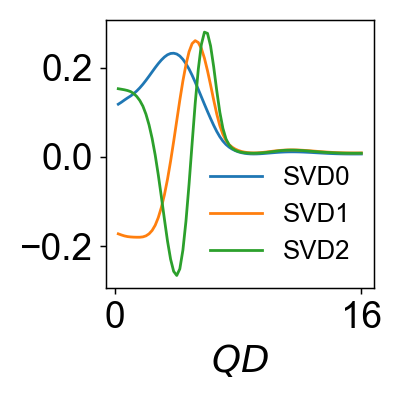

In [43]:
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot()
ax.plot(q,Vh[0]*sgn[0], label='SVD0')
ax.plot(q,Vh[1]*sgn[1], label='SVD1')
ax.plot(q,Vh[2]*sgn[2], label='SVD2')

ax.set_xticks([0,16])
ax.set_xlabel(r'$QD$',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(fontsize=14,framealpha=0,loc='lower right')

plt.tight_layout()
plt.show()

#### Z:
$Z = \sqrt{(A(1+1/2\kappa)^2)} $

#### x_V:
$A\exp(-(x-1)/\kappa)/x = 1$  
$x = \kappa W_n(A/\kappa \exp(1/\kappa))$, where $W_n$ is Lambert W-Function

#### A_eta:
$A\exp(-(r_{\eta}-1)/\kappa)/r_{\eta}$  
where $r_{\eta} = \eta^{-1/3}$

In [52]:
def Z(A,kappa):
    return np.sqrt(A*(1+1/2/kappa)**2)

def xV(A,kappa):
    return kappa*lambertw(A/kappa*np.exp(1/kappa))
            
def log_Aeta(A,kappa,eta):
    r_eta = (np.pi/6*eta)**(-1/3)
    return np.log(A) - np.log(r_eta) + (-(r_eta-1)/kappa)

parameters_list = fp_GT_list[:,0:3]
x_V = np.array([xV(A[i],kappa[i]) for i in range(len(A))]).real

log_A_eta = log_Aeta(A,kappa,eta)

z = Z(A,kappa)

parameters_list = np.c_[parameters_list,z,x_V,log_A_eta]

In [54]:
kappa

array([0.02, 0.02, 0.02, ..., 0.5 , 0.5 , 0.5 ], dtype=float32)

In [55]:
# fig = plt.figure(figsize=(6,6))
# ax = fig.add_subplot()

# a = 1
# k = 0.5

# r = (np.arange(1000)+1)/1000*10
# Vr = a*np.exp(-(r-1)/k)/r

# x = k*lambertw(a/k*np.exp(1/k)).real

# ax.set_ylim([0,10])

# plt.plot(r,Vr)
# plt.plot(r,Vr/Vr)
# plt.plot(x*np.ones(len(r)),Vr)
# plt.show()

<IPython.core.display.Javascript object>


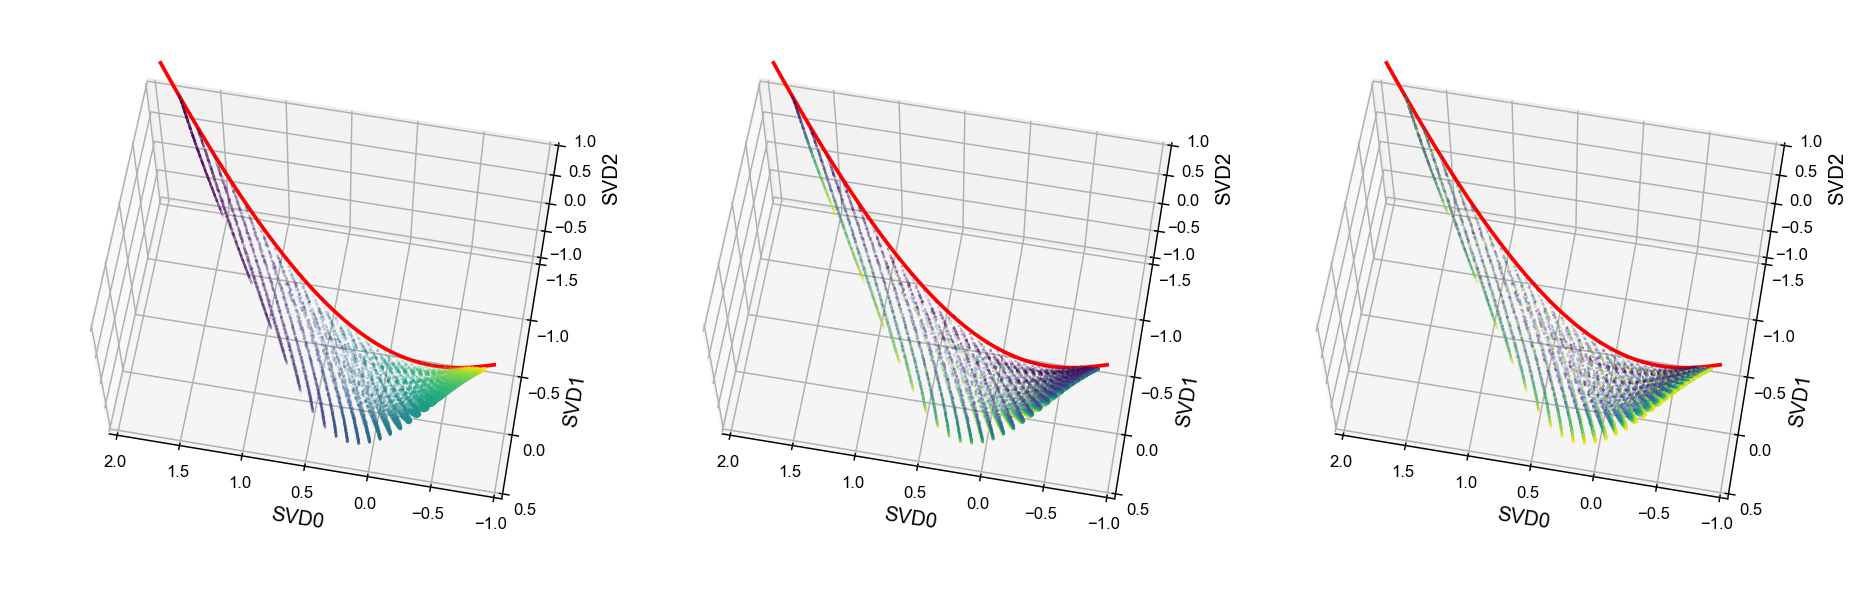

In [87]:
fig = plt.figure(figsize=(14,4.5))
index = np.array([0,1,2])
for i, parameter in enumerate(parameters_list[:,index].T):
    ax = fig.add_subplot(1,3,i+1,projection='3d')
    
    ax.scatter(FV[:,0],FV[:,1],FV[:,2], 
               s=0.02, c=parameter, #vmin=0, vmax=0.1,
               marker='o')
    ax.plot(FV_HS[:,0],FV_HS[:,1],FV_HS[:,2], '-r',lw=2)
    
#     ax.set_proj_type('persp')
    ax.set_box_aspect([3.0,2.0,2])
    
    az = 100
    el = 66
    x_az = np.sin(np.pi/180*az)
    y_az = np.cos(np.pi/180*az)
    y_el = np.sin(np.pi/180*el)
    z_el = np.cos(np.pi/180*el)
    tan_el_az = y_el*y_az/x_az
    rotation_x = np.arctan(tan_el_az)/np.pi*180
    rotation_y = np.arctan(tan_el_az)/np.pi*180
    ax.view_init(elev=el, azim=az)
    
    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)
    ax.set_xlabel('SVD0',fontsize=11, rotation=rotation_x)
    ax.set_ylabel('SVD1',fontsize=11, rotation=rotation_x+90)
    ax.set_zlabel('SVD2',fontsize=11, rotation=90)
    ax.set_xlim([-1,2])
    ax.set_ylim([-1.5,0.5])
    ax.set_zlim([-1,1])
    ax.set_xticks([-1,-0.5,0,0.5,1,1.5,2])
    ax.set_yticks([-1.5,-1,-0.5,0,0.5])
    ax.set_zticks([-1,-0.5,0,0.5,1])
    ax.tick_params(axis="x", direction='in', pad=1, which='major', labelsize=9)
    ax.tick_params(axis="y", direction='in', pad=1, which='major', labelsize=9)
    ax.tick_params(axis="z", direction='in', pad=1, which='major', labelsize=9)
    ax.xaxis.labelpad = 3
    ax.yaxis.labelpad = 1
    ax.zaxis.labelpad = 1
    
plt.tight_layout(pad=1.5)
plt.show()

<IPython.core.display.Javascript object>


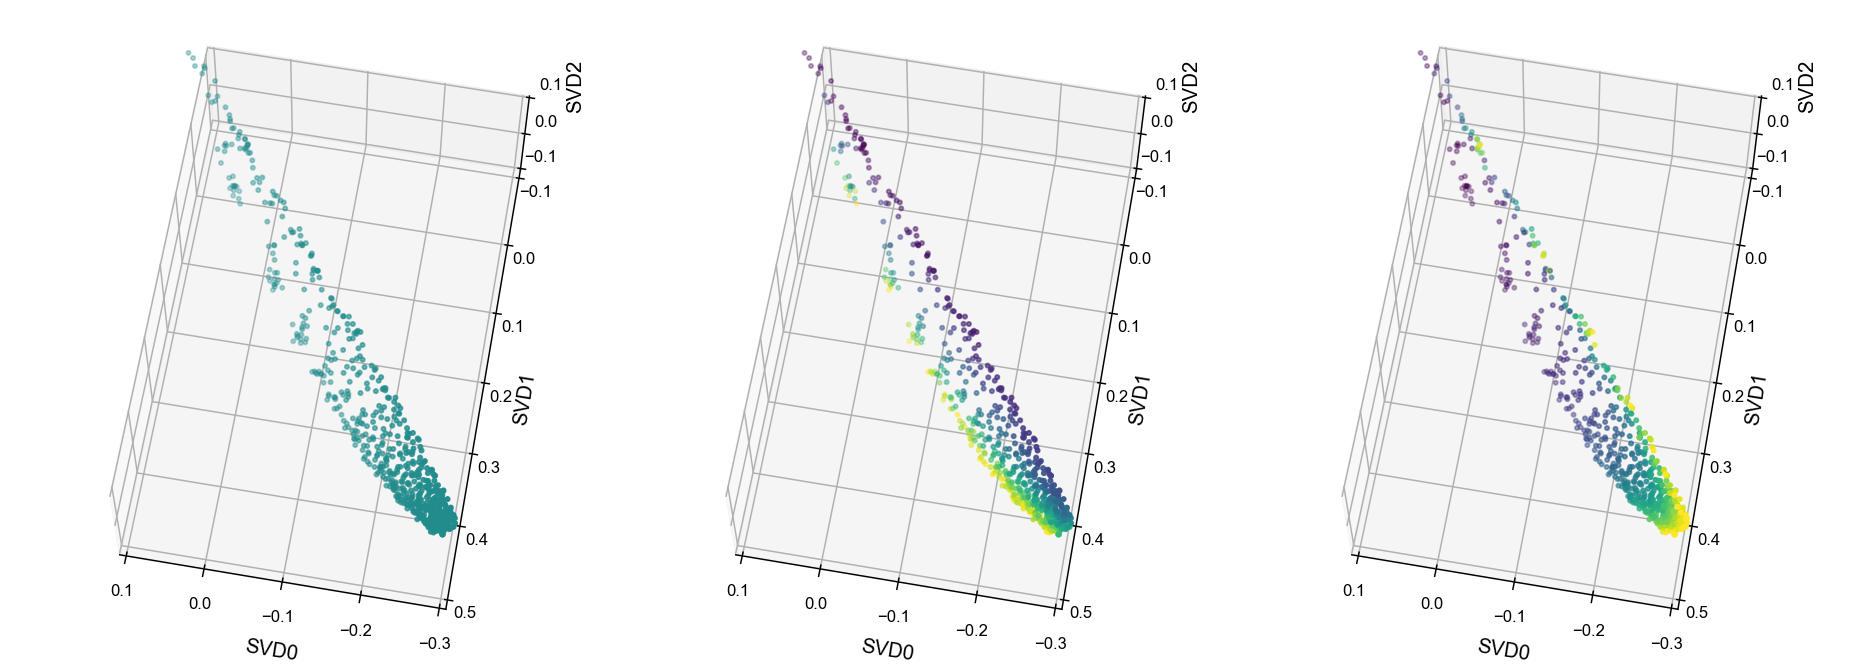

In [88]:
fig = plt.figure(figsize=(14,5))
index = np.array([0,1,2])
index_eta = eta==0.2250
for i, parameter in enumerate(parameters_list[:,index].T):
    ax = fig.add_subplot(1,3,i+1,projection='3d')
    
    ax.scatter(FV[index_eta,0],FV[index_eta,1],FV[index_eta,2], 
               s=5, c=parameter[index_eta], vmin=np.min(parameter), vmax=np.max(parameter),
               marker='o')
#     ax.plot(FV_HS[:,0],FV_HS[:,1],FV_HS[:,2], '-r',lw=2)
    
#     ax.set_proj_type('persp')
    ax.set_box_aspect([4,6,2])
    
    az = 100
    el = 66
    x_az = np.sin(np.pi/180*az)
    y_az = np.cos(np.pi/180*az)
    y_el = np.sin(np.pi/180*el)
    z_el = np.cos(np.pi/180*el)
    tan_el_az = y_el*y_az/x_az
    rotation_x = np.arctan(tan_el_az)/np.pi*180
    rotation_y = np.arctan(tan_el_az)/np.pi*180
    ax.view_init(elev=el, azim=az)
    
    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)
    ax.set_xlabel('SVD0',fontsize=11, rotation=rotation_x)
    ax.set_ylabel('SVD1',fontsize=11, rotation=rotation_x+90)
    ax.set_zlabel('SVD2',fontsize=11, rotation=90)
    ax.set_xlim([-0.3,0.1])
    ax.set_ylim([-0.1,0.5])
    ax.set_zlim([-0.1,0.1])
    ax.set_xticks([-0.3,-0.2,-0.1,0,0.1])
    ax.set_yticks([-0.1,0,0.1,0.2,0.3,0.4,0.5])
    ax.set_zticks([-0.1,0,0.1])
    ax.tick_params(axis="x", direction='in', pad=1, which='major', labelsize=9)
    ax.tick_params(axis="y", direction='in', pad=1, which='major', labelsize=9)
    ax.tick_params(axis="z", direction='in', pad=1, which='major', labelsize=9)
    ax.xaxis.labelpad = 1
    ax.yaxis.labelpad = 1
    ax.zaxis.labelpad = 1
    
plt.tight_layout(pad=1)
plt.show()

## Gradient

In [58]:
n_particle = len(F)
parameters = np.c_[eta,kappa,A] # potential parameters
score = FV[:,0:3] # first 3 SVD score

In [59]:
def expressiveness(parameters,score,std=0):
    # variation rate of SVD score wrt potential parameters
    '''
    find A minimize (AP - S)(AP - S)':
    A = SP’(PP’)^-1
    
    # Falk & Langer 1998
    #     X_ij = np.zeros([3,3])
    #     Y_ij = np.zeros([3,3])
    #     for i in range(n_particle):
    #         X_ij += np.outer(S[i],P[i])
    #         Y_ij += np.outer(P[i],P[i])

    #     epsilon = X_ij@np.linalg.inv(Y_ij)
    '''
    
    P = (parameters - np.mean(parameters,axis=0)).T
    S = (score - np.mean(score,axis=0)).T
    
    if std:
        P = (P/np.std(P,axis=0))
    #     S = (S/np.std(S,axis=0))

    epsilon = (S@P.T)@np.linalg.inv(P@P.T)
   
    return epsilon

def sensitivity(parameters,score,std=0):
    # variation rate of potential parameters wrt SVD score
    '''
    find B minimize (BS - P)(BS - P)':
    B = PS’(SS’)^-1
    
    # Falk & Langer 1998
    #     X_ij = np.zeros([3,3])
    #     Y_ij = np.zeros([3,3])
    #     for i in range(n_particle):
    #         X_ij += np.outer(S[i],P[i])
    #         Y_ij += np.outer(P[i],P[i])

    #     epsilon = X_ij@np.linalg.inv(Y_ij)
    '''
    
    P = (parameters - np.mean(parameters,axis=0)).T
    S = (score - np.mean(score,axis=0)).T
    
    if std:
        P = (P/np.std(P,axis=0))
    #     S = (S/np.std(S,axis=0))

    epsilon = (P@S.T)@np.linalg.inv(S@S.T)
   
    return epsilon

In [67]:
center = np.array([0.225,0.3,6])
index_parameters = ((eta-center[0])**2<=0.2**2)*((kappa-center[1])**2<=0.2**2)*((A-center[2])**2<=2**2)
# index_parameters = np.arange(n_particle)

E = expressiveness(parameters[index_parameters,:],score[index_parameters,:],std=0)
np.set_printoptions(precision=3)
print(E)
print('\n')

[[-4.823e+00 -8.753e-02 -1.885e-02]
 [ 1.652e+00  2.928e-01  2.440e-02]
 [ 1.470e+00 -4.589e-01 -3.948e-03]]




In [84]:
Q_E = E.T@E
print(Q_E)

[[2.815e+01 2.312e-01 1.254e-01]
 [2.312e-01 3.040e-01 1.061e-02]
 [1.254e-01 1.061e-02 9.662e-04]]


<IPython.core.display.Javascript object>


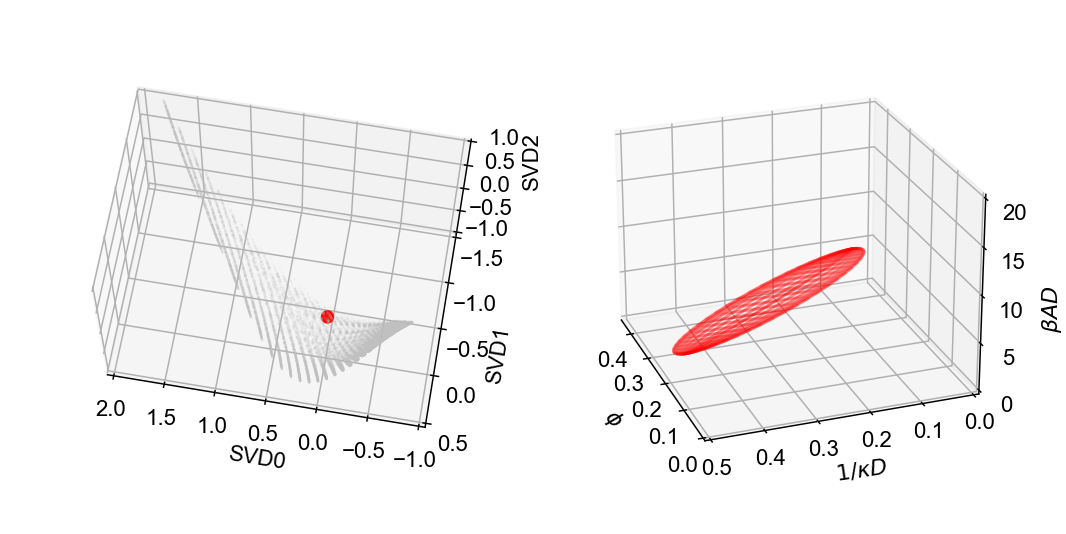

In [115]:
###### setting ######
#### SVD space ####
# radius and center in SVD space
r_SVD = 0.05
Q_SVD = np.eye(3)/r_SVD**2
center_SVD = np.array([0,0,0])

# find the rotation matrix and radii of the axes
U, s, rotation = np.linalg.svd(Q_SVD)
radii = 1.0/np.sqrt(s)

# https://stackoverflow.com/questions/7819498
u = np.linspace(0.0, 2.0 * np.pi, 100)
v = np.linspace(0.0, np.pi, 100)
x_S = radii[0] * np.outer(np.cos(u), np.sin(v))
y_S = radii[1] * np.outer(np.sin(u), np.sin(v))
z_S = radii[2] * np.outer(np.ones_like(u), np.cos(v))
for i in range(len(x)):
    for j in range(len(x)):
        [x_S[i,j],y_S[i,j],z_S[i,j]] = np.dot([x_S[i,j],y_S[i,j],z_S[i,j]], rotation) + center_SVD

#### parameter space ####
# ellispsoid and center in matrix form
Q = Q_E/r_SVD**2
center = np.array([0.225,0.3,6])

# find the rotation matrix and radii of the axes
U, s, rotation = np.linalg.svd(Q)
radii = 1.0/np.sqrt(s)

# https://stackoverflow.com/questions/7819498
u = np.linspace(0.0, 2.0 * np.pi, 100)
v = np.linspace(0.0, np.pi, 100)
x = radii[0] * np.outer(np.cos(u), np.sin(v))
y = radii[1] * np.outer(np.sin(u), np.sin(v))
z = radii[2] * np.outer(np.ones_like(u), np.cos(v))
for i in range(len(x)):
    for j in range(len(x)):
        [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], rotation) + center

        
        
        
        
###### plot ######
#### SVD space ####
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(121, projection='3d')

ax.scatter(FV[:,0],FV[:,1],FV[:,2], 
               s=0.1, c='#C0C0C0', #vmin=0, vmax=0.1,
               marker='.', alpha = 0.25)
# ax.plot(FV_HS[:,0],FV_HS[:,1],FV_HS[:,2], '-r',lw=2)

ax.plot_wireframe(x_S, y_S, z_S,  rstride=4, cstride=4, color='r', alpha=0.25)

#     ax.set_proj_type('persp')
ax.set_box_aspect([3.0,2.0,2])

az = 100
el = 66
x_az = np.sin(np.pi/180*az)
y_az = np.cos(np.pi/180*az)
y_el = np.sin(np.pi/180*el)
z_el = np.cos(np.pi/180*el)
tan_el_az = y_el*y_az/x_az
cot_el_az = y_el*x_az/y_az
rotation_x = np.arctan(tan_el_az)/np.pi*180
rotation_y = -np.arctan(cot_el_az)/np.pi*180
ax.view_init(elev=el, azim=az)

ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)
ax.set_xlabel('SVD0',fontsize=12, rotation=rotation_x)
ax.set_ylabel('SVD1',fontsize=12, rotation=rotation_x+90)
ax.set_zlabel('SVD2',fontsize=12, rotation=90)
ax.set_xlim([-1,2])
ax.set_ylim([-1.5,0.5])
ax.set_zlim([-1,1])
ax.set_xticks([-1,-0.5,0,0.5,1,1.5,2])
ax.set_yticks([-1.5,-1,-0.5,0,0.5])
ax.set_zticks([-1,-0.5,0,0.5,1])
ax.tick_params(axis="x", direction='in', pad=3, which='major', labelsize=12)
ax.tick_params(axis="y", direction='in', pad=3, which='major', labelsize=12)
ax.tick_params(axis="z", direction='in', pad=3, which='major', labelsize=12)
ax.xaxis.labelpad = 5
ax.yaxis.labelpad = 3
ax.zaxis.labelpad = 3


#### parameter space ####
ax = fig.add_subplot(122, projection='3d')

ax.plot_wireframe(x, y, z,  rstride=4, cstride=4, color='r', alpha=0.25)

az = 160
el = 24
x_az = np.sin(np.pi/180*az)
y_az = np.cos(np.pi/180*az)
y_el = np.sin(np.pi/180*el)
z_el = np.cos(np.pi/180*el)
tan_el_az = y_el*y_az/x_az
cot_el_az = y_el*x_az/y_az
rotation_x = np.arctan(tan_el_az)/np.pi*180
rotation_y = -np.arctan(cot_el_az)/np.pi*180
ax.view_init(elev=el, azim=az)

ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)
ax.set_xlabel(r'$\phi$',fontsize=12, rotation=rotation_x)
ax.set_ylabel(r'$1/\kappa D$',fontsize=12, rotation=rotation_y)
ax.set_zlabel(r'$\beta AD$',fontsize=12, rotation=90)
ax.set_xlim([0,0.45])
ax.set_ylim([0,0.5])
ax.set_zlim([0,20])
# ax.set_xticks([-0.3,-0.2,-0.1,0,0.1])
# ax.set_yticks([-0.1,0,0.1,0.2,0.3,0.4,0.5])
# ax.set_zticks([-0.1,0,0.1])
ax.tick_params(axis="x", direction='in', pad=1, which='major', labelsize=12)
ax.tick_params(axis="y", direction='in', pad=-1, which='major', labelsize=12)
ax.tick_params(axis="z", direction='in', pad=1, which='major', labelsize=12)
ax.xaxis.labelpad = 1
ax.yaxis.labelpad = -1
ax.zaxis.labelpad = 1
    
plt.tight_layout(pad=2.5)
plt.show()